In [74]:
import yfinance as yf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline


In [75]:
ticker = "NVDA" 
start_date = "2019-11-25"
end_date = "2024-12-18"
raw_data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [76]:
raw_data

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,,
2019-11-25,5.503102,5.530250,5.535250,5.388000,5.401000,506476000
2019-11-26,5.398368,5.425000,5.517250,5.418500,5.512500,385244000
2019-11-27,5.433222,5.456000,5.501250,5.429500,5.466750,215784000
2019-11-29,5.395879,5.418500,5.453500,5.394500,5.425000,141556000
2019-12-02,5.209410,5.231250,5.425000,5.216000,5.411500,372036000
...,...,...,...,...,...,...
2024-12-11,139.309998,139.309998,140.169998,135.210007,137.360001,184905200
2024-12-12,137.339996,137.339996,138.440002,135.800003,137.080002,159211400


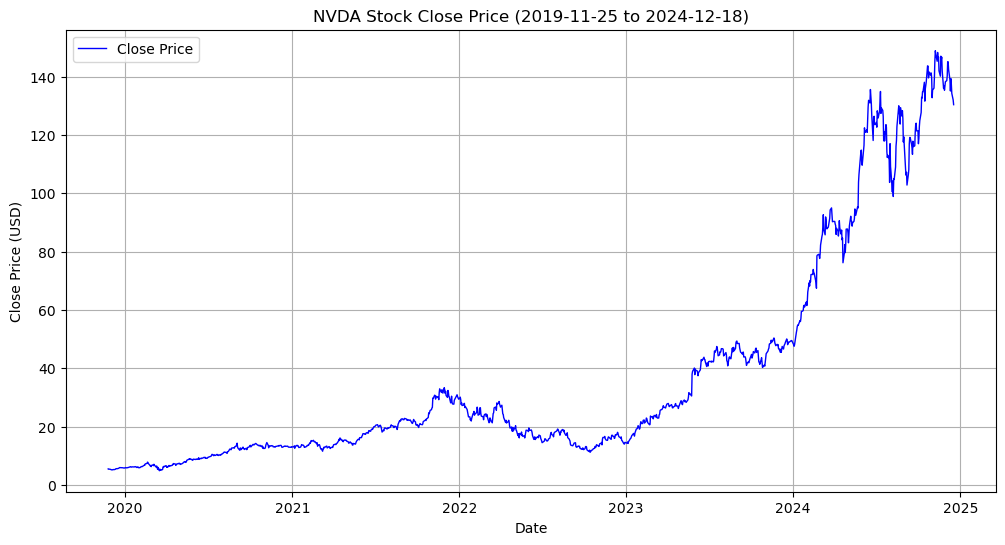

In [77]:
plt.figure(figsize=(12, 6))
plt.plot(raw_data.index, raw_data['Close'], color='blue', linewidth=1, label='Close Price')

# Add labels and title
plt.title(f"{ticker} Stock Close Price ({start_date} to {end_date})")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.grid(True)

In [78]:
data = raw_data['Close'].values.reshape(-1, 1)
data

array([[  5.53025007],
       [  5.42500019],
       [  5.45599985],
       ...,
       [134.25      ],
       [132.        ],
       [130.38999939]])

In [79]:
training_and_val = data[:int(0.9 * len(data))]
test = data[int(0.9 * len(data)):]

In [80]:
def build_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        input_sequence = data[i: i + time_steps]
        target = data[i+time_steps]

        X.append(input_sequence), y.append(target)
    return np.array(X), np.array(y)


from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
training_and_val_scaled = scaler.fit_transform(training_and_val)
test_scaled = scaler.transform(test)

In [81]:
training = training_and_val_scaled[int(0.8 * len(training_and_val_scaled)): ]
val = training_and_val_scaled[int(0.8 * len(training_and_val_scaled) + 1):]

In [82]:
x_train, y_train = build_sequences(training, 10)
x_val, y_val = build_sequences(val, 10)
x_test, y_test = build_sequences(test_scaled, 10)

In [83]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow import keras

# Build the LSTM model
model = Sequential([
    LSTM(units=50, activation = 'relu', input_shape=(x_train.shape[1], x_train.shape[2])),
    Dense(units=1)
])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [84]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)
# Train the model
model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data= (x_val, y_val), callbacks = [early_stopping])

# Evaluate the model
train_loss = model.evaluate(x_train, y_train, verbose=0)
test_loss = model.evaluate(x_test, y_test, verbose=0)
print(f'Train Loss: {train_loss:.6f}')
print(f'Test Loss: {test_loss:.6f}')

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2387 - val_loss: 0.1675
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1467 - val_loss: 0.0947
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0746 - val_loss: 0.0330
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0241 - val_loss: 0.0019
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - val_loss: 0.0106
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0082 - val_loss: 0.0019
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - val_loss: 0.0012


In [85]:
test_predictions = model.predict(x_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


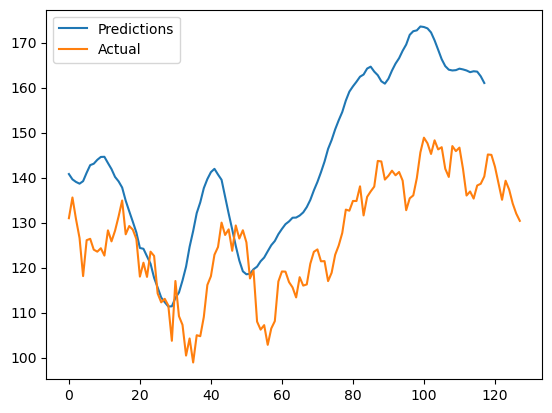

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline
predictions = scaler.inverse_transform(test_predictions)
actual = scaler.inverse_transform(test_scaled)

plt.plot(predictions, label = 'Predictions')
plt.plot(actual, label = 'Actual')
plt.legend()